In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Visual settings
%matplotlib inline
sns.set_theme(style="whitegrid")
print("Libraries Loaded.")

Libraries Loaded.


In [26]:
# 1. Load Data
df = pd.read_csv('../data/car_data.csv')

# 2. Aggressive Price Cleaning (Regex to remove RM and commas)
df['List_Price'] = df['List_Price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['List_Price'] = pd.to_numeric(df['List_Price'], errors='coerce')

# 3. Mileage Cleaning Function
def clean_mileage(text):
    if pd.isna(text) or text == '': return np.nan
    text = str(text).upper().replace('KM', '').replace(',', '').strip()
    if '-' in text: text = text.split('-')[-1].strip()
    if 'K' in text: return float(text.replace('K', '')) * 1000
    try: return float(text)
    except: return np.nan

df['Milleage'] = df['Milleage'].apply(clean_mileage)

# 4. Feature Engineering (Age as of 2026)
df['Year'] = df['Description'].str.extract(r'(\d{4})').astype(float)
df['Car_Age'] = 2026 - df['Year']

# 5. Filter for Mass Market (Under RM 200k) and drop NaNs
df_filtered = df[df['List_Price'] <= 200000].copy()
df_filtered = df_filtered.dropna(subset=['List_Price', 'Year', 'Milleage'])

print(f"Data Cleaned. Focused on {len(df_filtered)} mass-market cars.")

Data Cleaned. Focused on 857 mass-market cars.


In [27]:
# 1. Categorical Encoding (Top 10 Models)
top_models = df_filtered['Model'].value_counts().nlargest(10).index
df_filtered['Model_Filtered'] = df_filtered['Model'].where(df_filtered['Model'].isin(top_models), 'Other')

# Create Dummies
df_final = pd.get_dummies(df_filtered, columns=['Model_Filtered', 'Location', 'Gear_Type'], drop_first=True)

# 2. Define Features (X) and Target (y)
# Drop non-numeric columns and target
X = df_final.drop(['List_Price', 'Description', 'Monthly_Installment', 'Model', 'Year'], axis=1)
y = df_final['List_Price']

# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Evaluate
preds = rf_model.predict(X_test)
print(f"Final R2 Score: {r2_score(y_test, preds)*100:.2f}%")
print(f"Average Prediction Error: RM {mean_absolute_error(y_test, preds):.2f}")

# Save the model for future use
joblib.dump(rf_model, 'malaysia_car_predictor.pkl')

Final R2 Score: 35.38%
Average Prediction Error: RM 27260.93


['malaysia_car_predictor.pkl']

In [28]:
def get_car_valuation(age, mileage):
    # Create a blank template matching our training columns
    input_data = pd.DataFrame(columns=X.columns)
    input_data.loc[0] = 0 # Set everything to 0 (Baseline)
    
    input_data['Car_Age'] = age
    input_data['Milleage'] = mileage
    
    # Predict
    price = rf_model.predict(input_data)[0]
    return price

# TEST IT: 4-year-old car with 50,000km
user_age = 4
user_km = 50000
valuation = get_car_valuation(user_age, user_km)

print(f"--- Car Valuation Tool ---")
print(f"Age: {user_age} years")
print(f"Mileage: {user_km:,} KM")
print(f"Estimated Market Value: RM {valuation:,.2f}")

--- Car Valuation Tool ---
Age: 4 years
Mileage: 50,000 KM
Estimated Market Value: RM 119,613.87


In [29]:
# We create a "dummy" row that looks like your training data
# Let's check a 5-year-old car (2021) with 60,000km
sample_car = pd.DataFrame(X_test.iloc[0:1].copy()) # Take a template row

# Set the features manually
sample_car['Car_Age'] = 5 
sample_car['Milleage'] = 60000

# Predict!
predicted_price = rf_model.predict(sample_car)
print(f"The model predicts this car should cost: RM {predicted_price[0]:,.2f}")

The model predicts this car should cost: RM 106,407.01


In [30]:
# 1. Create a "Blank" car with all 0s (This resets brand and location)
sample_car_f = pd.DataFrame(columns=X_train_f.columns)
sample_car_f.loc[0] = 0 

# 2. Set the basic specs
sample_car_f['Car_Age'] = 5
sample_car_f['Milleage'] = 60000

# 3. Optional: Set a specific brand/location to 1 if you want
# If you leave them at 0, it predicts for the "Baseline" (usually the 'Other' category)

# 4. Predict using the FILTERED model
predicted_price_f = rf_filtered.predict(sample_car_f)

print(f"Prediction for a standard 5-year-old car: RM {predicted_price_f[0]:,.2f}")

Prediction for a standard 5-year-old car: RM 122,011.46


In [31]:
# We create a "dummy" row that looks like your training data
# Let's check a 5-year-old car (2021) with 60,000km
sample_car = pd.DataFrame(X_test.iloc[0:1].copy()) # Take a template row

# Set the features manually
sample_car['Car_Age'] = 5 
sample_car['Milleage'] = 60000

# Predict!
predicted_price = rf_model.predict(sample_car)
print(f"The model predicts this car should cost: RM {predicted_price[0]:,.2f}")

The model predicts this car should cost: RM 106,407.01


C:\Users\unkno\AppData\Local\Temp\ipykernel_41152\3786542671.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


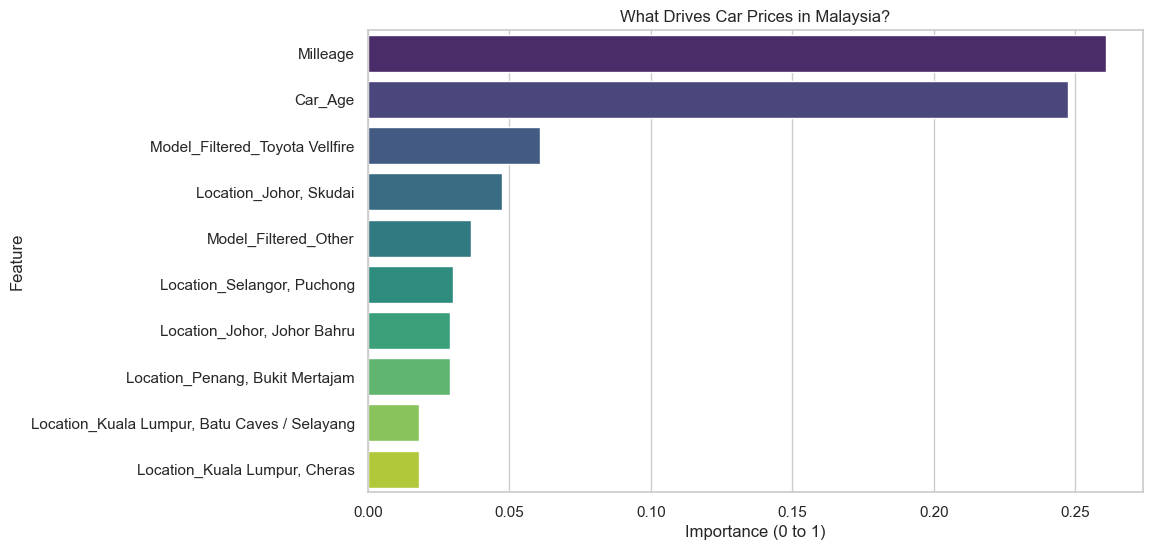

In [32]:
# Get importance from our filtered model
importances = rf_filtered.feature_importances_
feature_names = X_f.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and show the top 10
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('What Drives Car Prices in Malaysia?')
plt.xlabel('Importance (0 to 1)')
plt.show()

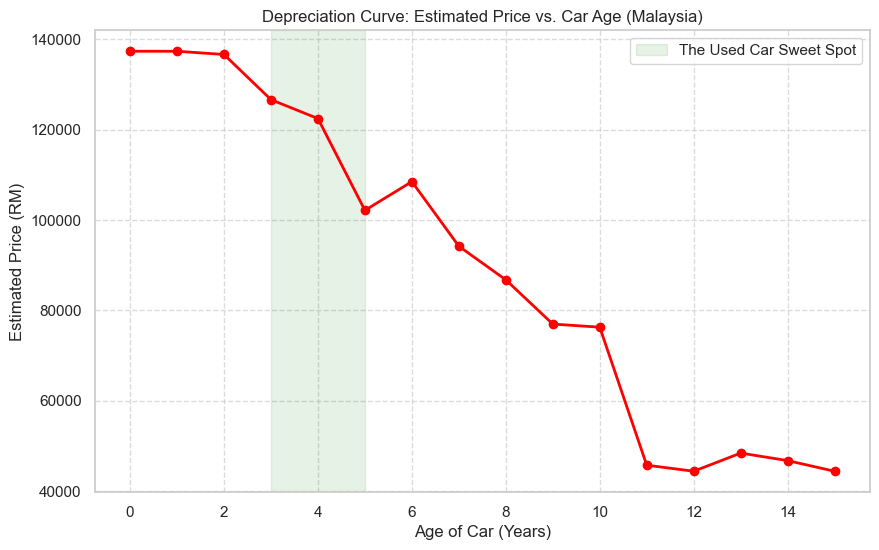

In [33]:
# Create a range of ages from 0 to 15 years
ages = np.arange(0, 16)
prices = []

# Predict price for each age assuming a fixed mileage (e.g., 15,000km per year)
for age in ages:
    mileage = age * 15000
    prices.append(get_car_valuation(age, mileage))

plt.figure(figsize=(10, 6))
plt.plot(ages, prices, marker='o', linestyle='-', color='red', linewidth=2)
plt.title('Depreciation Curve: Estimated Price vs. Car Age (Malaysia)')
plt.xlabel('Age of Car (Years)')
plt.ylabel('Estimated Price (RM)')
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the "Sweet Spot" (usually 3-5 years)
plt.axvspan(3, 5, color='green', alpha=0.1, label='The Used Car Sweet Spot')
plt.legend()
plt.show()

In [34]:
# This lists every brand and the number of cars found for each
brand_list = df['Model'].value_counts()
print(brand_list)

# If you just want a clean list of the names:
unique_brands = df['Model'].unique()
print(unique_brands)

Model
Mazda CX-5          33
Toyota Alphard      30
Honda City          30
Toyota Vellfire     27
Honda CR-V          26
                    ..
Kia Picanto          1
Ford Focus           1
Ford EcoSport        1
Proton Persona       1
Ssangyong Stavic     1
Name: count, Length: 167, dtype: int64
<StringArray>
[               'BMW 528i',             'Honda Civic',
                'BMW 328i',    'Toyota Corolla Altis',
            'Honda Accord',                'BMW 520i',
          'Toyota Harrier',                  'BMW X1',
                  'BMW X4',              'Honda HR-V',
 ...
               'Ford Kuga',           'Proton Ertiga',
                'Haval H1', 'Volkswagen Cross Touran',
             'Ford Fiesta',             'Kia Picanto',
              'Ford Focus',           'Ford EcoSport',
          'Proton Persona',        'Ssangyong Stavic']
Length: 168, dtype: str
